In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai import *
from fastai.vision import *

import torch
from torch import nn
from dsin.ae.data_manager.data_loader import (
    SideinformationImageImageList, ImageSiTuple)
from dsin.ae import config
from dsin.ae.base_ae import BaseAutoEncoder
from dsin.ae.si_autoenc import SideInformationAutoEncoder

from dsin.ae.si_net import SiNetChannelIn
from dsin.ae.loss_man import LossManager
from dsin.ae.distortions import Distortions, DistTypes
from dsin.ae.kitti_normalizer import ChangeImageStatsToKitti, ChangeState
from dsin.ae import config


from dsin.train_utils.visibilty_utils.logger_cb_utils import setup_file_logger
from dsin.train_utils.visibilty_utils.pbar_cb_utils import (AverageMetric,
                                            ParameterMetricCallback,
                                            ProgressBarAttibuteVisualizer,
                                            ParameterRunningAverageMetricCallback,
                                            BitEntropy
                                           )
from dsin.train_utils.save_utils import FileNameGenerator

In [3]:
bpp = 0.3
H_target = 2* bpp
# config.autoencoder_loss_distortion_to_minimize=DistTypes.MS_SSMIM
config.K_MS_SSIM=500
config.beta

500

In [4]:
logger = setup_file_logger()

In [5]:
config.use_si_flag = SiNetChannelIn.WithSideInformation

#  LOAD BASE-AE

In [6]:
baseline_autoencoder = BaseAutoEncoder()
path = "../src/dsin/data"
pct= 1 #0.0005 #0.25

valid_image_list = SideinformationImageImageList.from_csv(
    path=path, csv_names=["KITTI_stereo_val.txt"],pct=pct/10)
train_image_list = SideinformationImageImageList.from_csv(
    path=path, csv_names=["KITTI_stereo_train.txt"],pct=pct)

image_lists = ItemLists(
    path=path, train=train_image_list, valid=valid_image_list)

batchsize = 1

tfms =  get_transforms(do_flip=True,
                       flip_vert=False,
                       max_rotate=False,
                       max_zoom=0,
                       max_lighting=False,
                       max_warp=False)

data = (image_lists
        .label_from_func(lambda x: x)
        .transform(None, size=(336, 336), resize_method=ResizeMethod.CROP, tfm_y=True)
        .databunch(bs=batchsize))
learn = None 
gc.collect()
learn = Learner(data=data,
                     model=baseline_autoencoder,
                     opt_func=torch.optim.Adam,
                     loss_func=LossManager(baseline_autoencoder,SiNetChannelIn.NoSideInformation,use_feat_loss=False,target_bit_cost = H_target),
                     metrics=[AverageMetric(Distortions._calc_dist,"MS_SSIM")])
# learn.load('200815MAE-l2reg-baseline-1')
# learn.load('2020-08-28try2-MAE-l2reg-baseline-bpp0p10-9')
# 2020-08-29try2-MAE-l2reg-baseline-bpp0p30-8
trained_base_model_fname ='2020-09-04try2MSSIM-l2reg-baseline-bpp0p30-16'
learn.load(trained_base_model_fname)


Learner(data=ImageDataBunch;

Train: LabelList (1576 items)
x: SideinformationImageImageList
ImageSiTuple tensor([[[1.0000, 1.0000, 1.0000,  ..., 0.6465, 0.5606, 0.4442],
         [1.0000, 1.0000, 1.0000,  ..., 0.8471, 0.6217, 0.3216],
         [1.0000, 1.0000, 1.0000,  ..., 0.4640, 0.3560, 0.2957],
         ...,
         [0.1550, 0.1939, 0.1864,  ..., 0.1565, 0.1676, 0.1823],
         [0.1568, 0.1858, 0.1860,  ..., 0.1578, 0.1650, 0.1670],
         [0.1603, 0.1834, 0.1804,  ..., 0.1589, 0.1608, 0.1647]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.6385, 0.4861, 0.3774],
         [1.0000, 1.0000, 1.0000,  ..., 0.7271, 0.5477, 0.2751],
         [1.0000, 1.0000, 1.0000,  ..., 0.6805, 0.4184, 0.2245],
         ...,
         [0.1924, 0.2211, 0.2177,  ..., 0.1893, 0.1998, 0.1952],
         [0.1898, 0.2229, 0.2052,  ..., 0.1811, 0.2007, 0.1996],
         [0.1986, 0.2157, 0.2199,  ..., 0.1912, 0.2059, 0.1923]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.2690, 0.4330, 0.2803],
         [1.0000,

## Freeze Base AE before training first time with SI-AE

In [7]:
learn.freeze_to(-1)

# Create  SI-AE

In [8]:
si_autoencoder = SideInformationAutoEncoder(base_line_auto_enc = learn.model)


learn = Learner(data=data,
                     model=si_autoencoder,
                     opt_func=torch.optim.Adam,
                     loss_func=LossManager(si_autoencoder,SiNetChannelIn.WithSideInformation,use_feat_loss=False,target_bit_cost = H_target), #True
                     metrics=[AverageMetric(Distortions._calc_dist,"MS_SSIM")])

In [9]:
model_fname =FileNameGenerator.create_fname(f'sinet-MAE-l2reg-si-nofeat-bpp0p{bpp*100:.0f}')
lrs = [1e-4] *3 + [1e-5]  * 2
model_fname

'2020-09-05sinet-MAE-l2reg-si-nofeat-bpp0p30'

In [10]:
config.si_loss_weight_alpha = 0.7
learn.model.use_side_infomation = SiNetChannelIn.WithSideInformation
learn.loss_func.use_side_infomation = SiNetChannelIn.WithSideInformation

offset = 0
if offset!= 0 :
    learn.load(f'{model_fname}-{offset - 1}',with_opt=True)
for i,lr in zip(range(offset,len(lrs)),lrs[offset:]):
    learn.fit(1, lr=lr,wd=0,callbacks=[ParameterRunningAverageMetricCallback(learn.loss_func),BitEntropy(loss_man=learn.loss_func,logger=logger,use_si=True)])
    learn.save(f'{model_fname}-{i}')
#     !aws s3 cp ~/tDSIN/src/dsin/data/models/{model_fname}-{i}.pth  s3://dsin-us/models/
#     !aws s3 cp ~/tDSIN/tutorials/out.log s3://dsin-us/models/{model_fname}-{i}.log


epoch,train_loss,valid_loss,MS_SSIM,time
0,55.469650,194.329056,0.331727,06:46


iter 0: bpp = 0.030 imp-mean-var(0.10 0.09) total loss116.6  l2reg_loss=19.0autoencoder_loss_value=17.8si_loss=128.8feat_loss_value=0.0
iter 500: bpp = 0.170 imp-mean-var(0.02 0.02) total loss52.5  l2reg_loss=18.7autoencoder_loss_value=39.8si_loss=38.0feat_loss_value=0.0
iter 1000: bpp = 0.249 imp-mean-var(0.07 0.07) total loss59.6  l2reg_loss=18.4autoencoder_loss_value=46.0si_loss=35.1feat_loss_value=0.0
iter 1500: bpp = 0.261 imp-mean-var(0.08 0.07) total loss40.4  l2reg_loss=18.2autoencoder_loss_value=25.9si_loss=26.1feat_loss_value=0.0


epoch,train_loss,valid_loss,MS_SSIM,time
0,45.312366,90.003250,0.255763,06:45


iter 0: bpp = 0.028 imp-mean-var(0.10 0.09) total loss42.1  l2reg_loss=18.2autoencoder_loss_value=23.4si_loss=22.8feat_loss_value=0.0
iter 500: bpp = 0.269 imp-mean-var(0.11 0.10) total loss45.3  l2reg_loss=18.0autoencoder_loss_value=25.9si_loss=25.1feat_loss_value=0.0
iter 1000: bpp = 0.270 imp-mean-var(0.11 0.10) total loss41.1  l2reg_loss=17.8autoencoder_loss_value=24.0si_loss=22.9feat_loss_value=0.0
iter 1500: bpp = 0.260 imp-mean-var(0.08 0.07) total loss35.6  l2reg_loss=17.7autoencoder_loss_value=19.5si_loss=26.1feat_loss_value=0.0


epoch,train_loss,valid_loss,MS_SSIM,time
0,42.923096,73.637688,0.236420,06:44


iter 0: bpp = 0.031 imp-mean-var(0.12 0.10) total loss50.5  l2reg_loss=17.6autoencoder_loss_value=22.7si_loss=20.7feat_loss_value=0.0
iter 500: bpp = 0.267 imp-mean-var(0.11 0.10) total loss45.1  l2reg_loss=17.5autoencoder_loss_value=25.7si_loss=23.7feat_loss_value=0.0
iter 1000: bpp = 0.280 imp-mean-var(0.10 0.09) total loss39.0  l2reg_loss=17.4autoencoder_loss_value=21.6si_loss=22.3feat_loss_value=0.0
iter 1500: bpp = 0.283 imp-mean-var(0.14 0.12) total loss66.2  l2reg_loss=17.3autoencoder_loss_value=16.5si_loss=23.8feat_loss_value=0.0


epoch,train_loss,valid_loss,MS_SSIM,time
0,39.775703,53.186962,0.230726,06:42


iter 0: bpp = 0.032 imp-mean-var(0.13 0.11) total loss66.6  l2reg_loss=17.2autoencoder_loss_value=28.4si_loss=27.5feat_loss_value=0.0
iter 500: bpp = 0.284 imp-mean-var(0.10 0.09) total loss35.9  l2reg_loss=17.2autoencoder_loss_value=18.6si_loss=21.0feat_loss_value=0.0
iter 1000: bpp = 0.282 imp-mean-var(0.10 0.09) total loss42.7  l2reg_loss=17.2autoencoder_loss_value=24.6si_loss=20.2feat_loss_value=0.0
iter 1500: bpp = 0.282 imp-mean-var(0.10 0.09) total loss36.6  l2reg_loss=17.2autoencoder_loss_value=18.9si_loss=18.1feat_loss_value=0.0


epoch,train_loss,valid_loss,MS_SSIM,time


iter 0: bpp = 0.027 imp-mean-var(0.10 0.09) total loss34.1  l2reg_loss=17.2autoencoder_loss_value=17.3si_loss=15.5feat_loss_value=0.0


KeyboardInterrupt: 

In [11]:
model_fname, i

('2020-09-05sinet-MAE-l2reg-si-nofeat-bpp0p30', 4)

In [12]:

!aws s3 cp ~/tDSIN/src/dsin/data/models/{model_fname}-{i-1}.pth  s3://dsin-us/models/
!aws s3 cp ~/tDSIN/tutorials/out.log s3://dsin-us/models/{model_fname}-{i-1}.log


upload: ../src/dsin/data/models/2020-09-05sinet-MAE-l2reg-si-nofeat-bpp0p30-3.pth to s3://dsin-us/models/2020-09-05sinet-MAE-l2reg-si-nofeat-bpp0p30-3.pth
upload: ./out.log to s3://dsin-us/models/2020-09-05sinet-MAE-l2reg-si-nofeat-bpp0p30-3.log


In [30]:
learn.fit(1, lr=lr,wd=0,callbacks=[ParameterRunningAverageMetricCallback(learn.loss_func),BitEntropy(loss_man=learn.loss_func,logger=logger,use_si=True)])

epoch,train_loss,valid_loss,MS_SSIM,time


iter 0: bpp = 0.031 imp-mean-var(0.14 0.12) total loss49.4  l2reg_loss=16.5autoencoder_loss_value=20.6si_loss=19.5feat_loss_value=0.0


KeyboardInterrupt: 

In [20]:
ydec = torch.load('ydec')

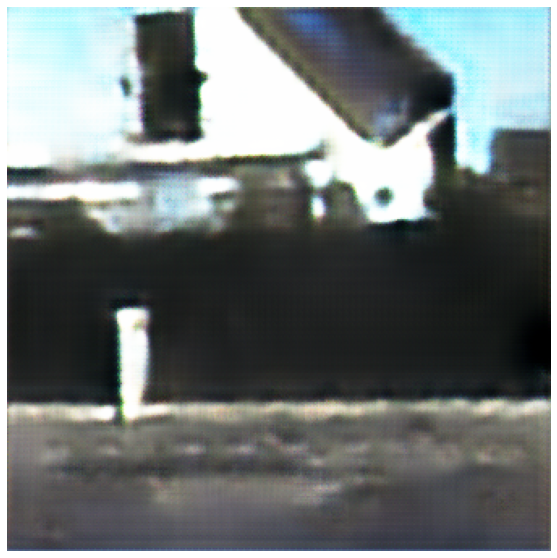

In [23]:
mt = ydec.squeeze_().detach()
mx, mn =torch.max(mt), torch.min(mt)
diff = mx-mn
show_image(Image(mt),figsize=(10,10))

In [ ]:
lrs = [1e-4] *3 + [1e-5]  * 4


In [ ]:
offset = 5
for i,lr in zip(range(offset,len(lrs)),lrs[offset:]):
    if i != 0:
        learn.load(f'{model_fname}-{i - 1}',with_opt=True)
    learn.fit(1, lr=lr,wd=0,callbacks=[ParameterRunningAverageMetricCallback(learn.loss_func),BitEntropy(loss_man=learn.loss_func,logger=logger,use_si=True)])
    learn.save(f'{model_fname}-{i}')
    !aws s3 cp ~/tDSIN/src/dsin/data/models/{model_fname}-{i}.pth  s3://dsin-us/models/
    !aws s3 cp ~/tDSIN/tutorials/out.log s3://dsin-us/models/{model_fname}-{i}.log


In [ ]:
learn.unfreeze()


In [ ]:
model_fname =FileNameGenerator.create_fname(f'MAE-l2reg-si-nofeat-bpp0p{bpp*100:.0f}-unfrzd')
lrs = [1e-5] *3 + [1e-6] *3 + [1e-7] * 2
model_fname

In [ ]:
offset = 0
for i,lr in zip(range(offset,len(lrs)),lrs[offset:]):
    if i != 0:
        learn.load(f'{model_fname}-{i - 1}',with_opt=True)
    learn.fit(1, lr=lr,wd=0,callbacks=[ParameterRunningAverageMetricCallback(learn.loss_func),BitEntropy(loss_man=learn.loss_func,logger=logger,use_si=True)])
    learn.save(f'{model_fname}-{i}')

In [ ]:


!aws s3 cp ~/tDSIN/src/dsin/data/models/{model_fname}-{i}.pth  s3://dsin-us/models/
!aws s3 cp ~/tDSIN/tutorials/out.log s3://dsin-us/models/{model_fname}-{i}.log

In [ ]:
lrs = [1e-5] *3 + [1e-6] *3 + [1e-7] * 2
offset = 6
for i,lr in zip(range(offset,len(lrs)),lrs[offset:]):
    if i != 0:
        learn.load(f'{model_fname}-{i - 1}',with_opt=True)
    learn.fit(1, lr=lr,wd=0,callbacks=[ParameterRunningAverageMetricCallback(learn.loss_func),BitEntropy(loss_man=learn.loss_func,logger=logger,use_si=True)])
    learn.save(f'{model_fname}-{i}')
    !aws s3 cp ~/tDSIN/src/dsin/data/models/{model_fname}-{i}.pth  s3://dsin-us/models/
    !aws s3 cp ~/tDSIN/tutorials/out.log s3://dsin-us/models/{model_fname}-{i}.log

In [ ]:
learn.data.train_ds[1][0].img

In [11]:
learn.load(f'2020-09-05sinet-MAE-l2reg-si-nofeat-bpp0p30-3',with_opt=True)

Learner(data=ImageDataBunch;

Train: LabelList (1576 items)
x: SideinformationImageImageList
ImageSiTuple tensor([[[1.0000, 1.0000, 1.0000,  ..., 0.6465, 0.5606, 0.4442],
         [1.0000, 1.0000, 1.0000,  ..., 0.8471, 0.6217, 0.3216],
         [1.0000, 1.0000, 1.0000,  ..., 0.4640, 0.3560, 0.2957],
         ...,
         [0.1550, 0.1939, 0.1864,  ..., 0.1565, 0.1676, 0.1823],
         [0.1568, 0.1858, 0.1860,  ..., 0.1578, 0.1650, 0.1670],
         [0.1603, 0.1834, 0.1804,  ..., 0.1589, 0.1608, 0.1647]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.6385, 0.4861, 0.3774],
         [1.0000, 1.0000, 1.0000,  ..., 0.7271, 0.5477, 0.2751],
         [1.0000, 1.0000, 1.0000,  ..., 0.6805, 0.4184, 0.2245],
         ...,
         [0.1924, 0.2211, 0.2177,  ..., 0.1893, 0.1998, 0.1952],
         [0.1898, 0.2229, 0.2052,  ..., 0.1811, 0.2007, 0.1996],
         [0.1986, 0.2157, 0.2199,  ..., 0.1912, 0.2059, 0.1923]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.2690, 0.4330, 0.2803],
         [1.0000,

In [ ]:
learn.data.train_ds[1][0].si_img

In [ ]:
learn.loss_func.soft_bit_entropy

In [ ]:
config.si_loss_weight_alpha

In [ ]:
learn.loss_func.autoencoder_loss_value

In [ ]:
mt = learn.model.my_tuple[5].squeeze_().detach()
mx, mn =torch.max(mt), torch.min(mt)
diff = mx-mn
show_image(Image(mt),figsize=(10,10))
# # print(mn)

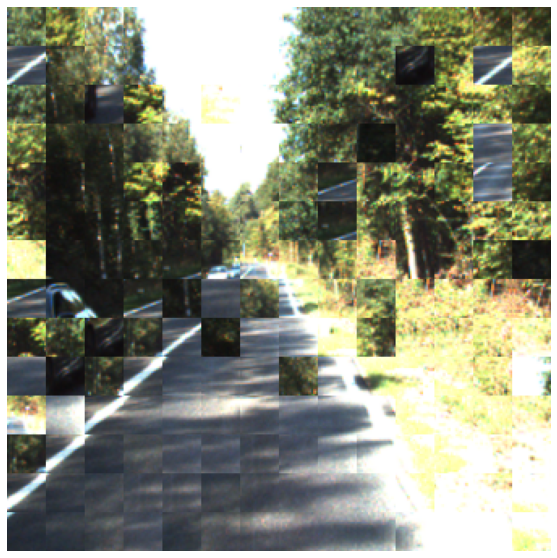

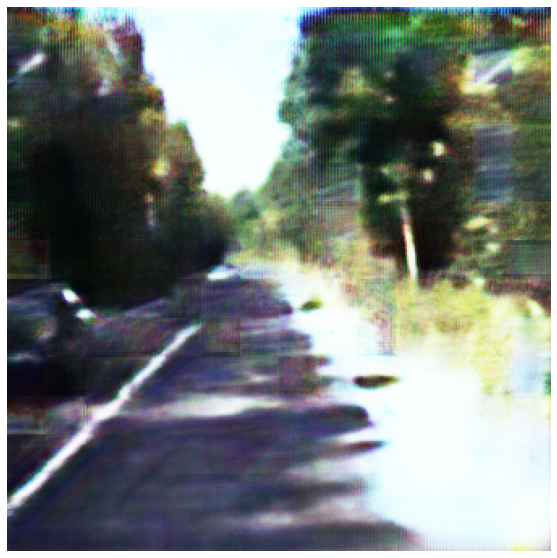

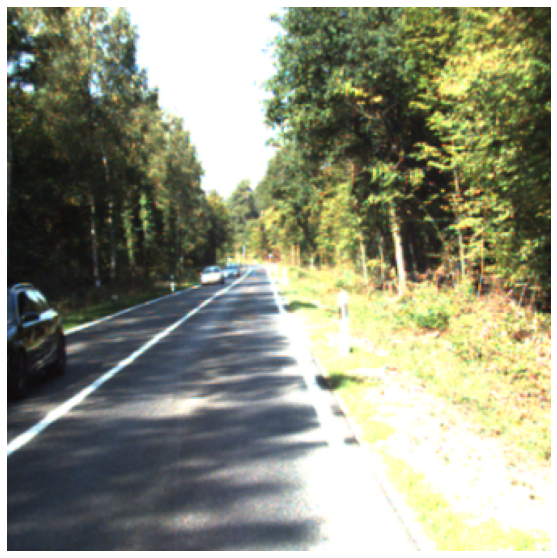

In [14]:

# # show_image(Image(learn.model.my_tuple[0][:,:50,:50]/255))
# # Image(learn.model.my_tuple[2].squeeze_().detach()/255.0)
mt = learn.model.my_tuple[0].squeeze_().detach() / 255.0
show_image(Image(mt),figsize=(10,10))

mt = learn.model.my_tuple[2].squeeze_().detach()
show_image(Image(mt),figsize=(10,10))

mt = learn.model.my_tuple[-2].squeeze_().detach() 
show_image(Image(mt),figsize=(10,10))


tensor([[[255.0000, 255.0000, 255.0000,  ..., 255.0000, 255.0000, 255.0000],
         [255.0000, 255.0000, 255.0000,  ..., 255.0000, 255.0000, 255.0000],
         [255.0000, 255.0000, 255.0000,  ..., 255.0000, 255.0000, 255.0000],
         ...,
         [255.0000, 255.0000, 255.0000,  ..., 255.0000, 255.0000, 255.0000],
         [255.0000, 255.0000, 255.0000,  ..., 255.0000, 255.0000, 255.0000],
         [255.0000, 255.0000, 255.0000,  ..., 255.0000, 255.0000, 255.0000]],

        [[255.0000, 255.0000, 255.0000,  ..., 255.0000, 255.0000, 255.0000],
         [255.0000, 255.0000, 255.0000,  ..., 255.0000, 255.0000, 255.0000],
         [255.0000, 255.0000, 255.0000,  ..., 255.0000, 255.0000, 255.0000],
         ...,
         [255.0000, 255.0000, 255.0000,  ..., 255.0000, 255.0000, 255.0000],
         [255.0000, 255.0000, 255.0000,  ..., 255.0000, 255.0000, 255.0000],
         [255.0000, 255.0000, 255.0000,  ..., 255.0000, 255.0000, 255.0000]],

        [[255.0000, 255.0000, 255.0000,  ...

In [ ]:
aaa = (mt - mn)/(diff)

flip_lr(Image(aaa.cpu()))

In [ ]:
# learn.model.true_tuple_loss_false_just_out = False

# learn.show_results(figsize=(30,30))

In [ ]:
learn.model.my_tuple[-2].data

In [13]:
lr = 1e-5
learn.fit(1, lr=lr,wd=0,callbacks=[ParameterRunningAverageMetricCallback(learn.loss_func),BitEntropy(loss_man=learn.loss_func,logger=logger,use_si=True)])

epoch,train_loss,valid_loss,MS_SSIM,time


iter 0: bpp = 0.027 imp-mean-var(0.10 0.09) total loss40.8  l2reg_loss=17.2autoencoder_loss_value=20.7si_loss=23.7feat_loss_value=0.0


KeyboardInterrupt: 